# Wavelength frame multiplication

Wavelength frame multiplication (WFM) is a technique commonly used at long-pulse facilities to improve the resolution of the results measured at the neutron detectors.
See for example the article by [Schmakat et al. (2020)](https://doi.org/10.1016/j.nima.2020.164467) for a description of how WFM works.

In this notebook, we show how to use `essreduce`'s `time_of_flight` module to compute an accurate a time-of-flight coordinate,
from which a wavelength can be computed.

In [1]:
import numpy as np
import plopp as pp
import scipp as sc
import scippnexus as snx
from scippneutron.chopper import DiskChopper
from ess.reduce.nexus.types import AnyRun, RawDetector, SampleRun, NeXusDetectorName
from ess.reduce.time_of_flight import *

## Setting up the beamline

### Creating the beamline choppers

We begin by defining the chopper settings for our beamline.
In principle, the chopper setting could simply be read from a NeXus file.

For this example, we create choppers modeled on the [V20 ESS beamline at HZB](https://doi.org/10.1016/j.nima.2016.09.034).
It consists of 5 choppers:

- 2 WFM choppers
- 2 frame-overlap choppers
- 1 pulse-overlap chopper

The first 4 choppers have 6 openings (also known as cutouts),
while the last one only has a single opening.

In [2]:
wfm1 = DiskChopper(
    frequency=sc.scalar(-70.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(-47.10, unit="deg"),
    axle_position=sc.vector(value=[0, 0, 6.6], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=np.array([83.71, 140.49, 193.26, 242.32, 287.91, 330.3]) + 15.0,
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=np.array([94.7, 155.79, 212.56, 265.33, 314.37, 360.0]) + 15.0,
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

wfm2 = DiskChopper(
    frequency=sc.scalar(-70.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(-76.76, unit="deg"),
    axle_position=sc.vector(value=[0, 0, 7.1], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=np.array([65.04, 126.1, 182.88, 235.67, 284.73, 330.32]) + 15.0,
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=np.array([76.03, 141.4, 202.18, 254.97, 307.74, 360.0]) + 15.0,
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

foc1 = DiskChopper(
    frequency=sc.scalar(-56.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(-62.40, unit="deg"),
    axle_position=sc.vector(value=[0, 0, 8.8], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=np.array([74.6, 139.6, 194.3, 245.3, 294.8, 347.2]),
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=np.array([95.2, 162.8, 216.1, 263.1, 310.5, 371.6]),
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

foc2 = DiskChopper(
    frequency=sc.scalar(-28.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(-12.27, unit="deg"),
    axle_position=sc.vector(value=[0, 0, 15.9], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=np.array([98.0, 154.0, 206.8, 255.0, 299.0, 344.65]),
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=np.array([134.6, 190.06, 237.01, 280.88, 323.56, 373.76]),
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

pol = DiskChopper(
    frequency=sc.scalar(-14.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(0.0, unit="deg"),
    axle_position=sc.vector(value=[0, 0, 17.0], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=np.array([40.0]),
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=np.array([240.0]),
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

disk_choppers = {"wfm1": wfm1, "wfm2": wfm2, "foc1": foc1, "foc2": foc2, "pol": pol}

It is possible to visualize the properties of the choppers by inspecting their `repr`:

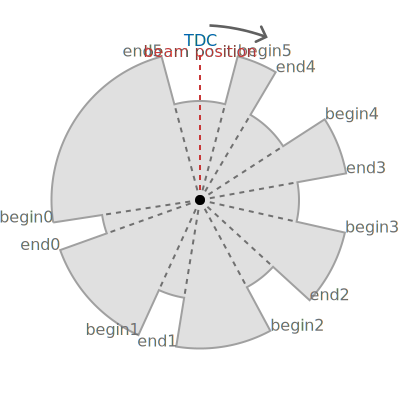

In [3]:
wfm1

Define the source position which is required to compute the distance that neutrons travelled.
In this example, chopper positions are given relative to the source, so we set the source position to the origin.

In [4]:
source_position = sc.vector([0, 0, 0], unit="m")

### Adding a detector

We also have a detector, which we place 26 meters away from the source.

In [5]:
Ltotal = sc.scalar(26.0, unit="m")

## Creating some neutron events

We create a semi-realistic set of neutron events based on the ESS pulse.

In [6]:
from ess.reduce.time_of_flight.fakes import FakeBeamline

ess_beamline = FakeBeamline(
    choppers=disk_choppers,
    source_position=source_position,
    monitors={"detector": Ltotal},
    run_length=sc.scalar(1 / 14, unit="s") * 14,
    events_per_pulse=200_000,
)

The initial birth times and wavelengths of the generated neutrons can be visualized (for a single pulse):

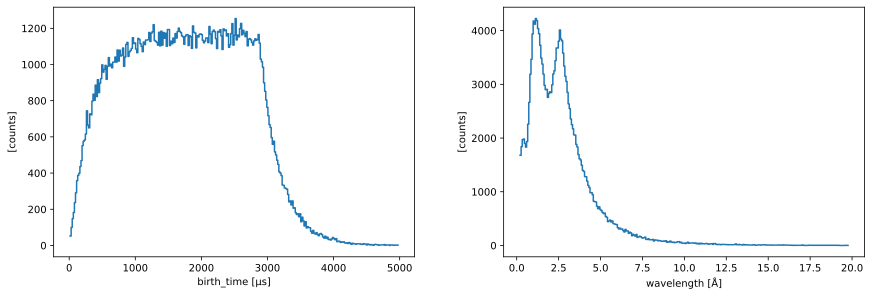

In [7]:
one_pulse = ess_beamline.source.data["pulse", 0]
one_pulse.hist(birth_time=300).plot() + one_pulse.hist(wavelength=300).plot()

From this fake beamline, we extract the raw neutron signal at our detector:

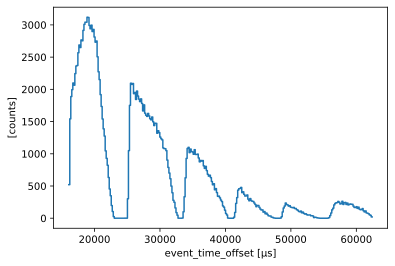

In [8]:
raw_data = ess_beamline.get_monitor("detector")[0]

# Visualize
raw_data.hist(event_time_offset=300).squeeze().plot()

The total number of neutrons in our sample data that make it through the to detector is:

In [9]:
raw_data.sum().value

np.float64(204163.0)

## Computing time-of-flight

Next, we use a workflow that provides an estimate of the real time-of-flight as a function of neutron time-of-arrival.

### Setting up the workflow

In [10]:
wf = GenericTofWorkflow(run_types=[SampleRun], monitor_types=[])

wf[RawDetector[SampleRun]] = raw_data
wf[DetectorLtotal[SampleRun]] = Ltotal
wf[NeXusDetectorName] = "detector"

wf.visualize(TofDetector[SampleRun])

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

By default, the workflow tries to load a `TofLookupTable` from a file.

In this notebook, instead of using such a pre-made file,
we will build our own lookup table from the chopper information and apply it to the workflow.

### Building the time-of-flight lookup table

We use the [Tof](https://scipp.github.io/tof/) package to propagate a pulse of neutrons through the chopper system to the detectors,
and predict the most likely neutron wavelength for a given time-of-arrival and distance from source.

From this,
we build a lookup table on which bilinear interpolation is used to compute a wavelength (and its corresponding time-of-flight)
for every neutron event.

In [11]:
lut_wf = TofLookupTableWorkflow()
lut_wf[DiskChoppers[AnyRun]] = disk_choppers
lut_wf[SourcePosition] = source_position
lut_wf[LtotalRange] = sc.scalar(5, unit='m'), sc.scalar(35, unit='m')
lut_wf.visualize(TofLookupTable)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Inspecting the lookup table

The workflow first runs a simulation using the chopper parameters above,
and the result is stored in `SimulationResults` (see graph above).

From these simulated neutrons, we create figures displaying the neutron wavelengths and time-of-flight,
as a function of arrival time at the detector.

This is the basis for creating our lookup table.

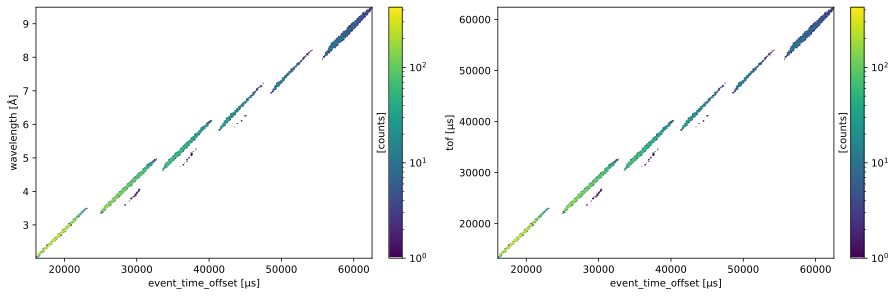

In [12]:
sim = lut_wf.compute(SimulationResults)


def to_event_time_offset(sim):
    # Compute event_time_offset at the detector
    eto = (
        sim.time_of_arrival + ((Ltotal - sim.distance) / sim.speed).to(unit="us")
    ) % sc.scalar(1e6 / 14.0, unit="us")
    # Compute time-of-flight at the detector
    tof = (Ltotal / sim.speed).to(unit="us")
    return sc.DataArray(
        data=sim.weight,
        coords={"wavelength": sim.wavelength, "event_time_offset": eto, "tof": tof},
    )


events = to_event_time_offset(sim.readings["pol"])
fig1 = events.hist(wavelength=300, event_time_offset=300).plot(norm="log")
fig2 = events.hist(tof=300, event_time_offset=300).plot(norm="log")
fig1 + fig2

The lookup table is then obtained by computing the weighted mean of the time-of-flight inside each time-of-arrival bin.

This is illustrated by the orange line in the figure below:

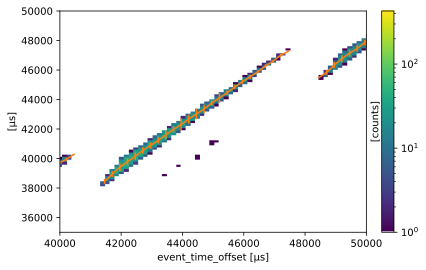

In [13]:
table = lut_wf.compute(TofLookupTable)

# Overlay mean on the figure above
table.array["distance", 212].plot(ax=fig2.ax, color="C1", ls="-", marker=None)

# Zoom in
fig2.canvas.xrange = 40000, 50000
fig2.canvas.yrange = 35000, 50000
fig2

We can see that the orange lines follow the center of the colored areas.

We can also see that in regions where there is contamination from other chopper openings (overlapping regions in time),
the error bars on the orange line get larger.

Another way of looking at this is to plot the entire table,
showing the predicted time-of-flight as a function of `event_time_offset` and distance.
We also show alongside it the standard deviation of the predicted time-of-flight.

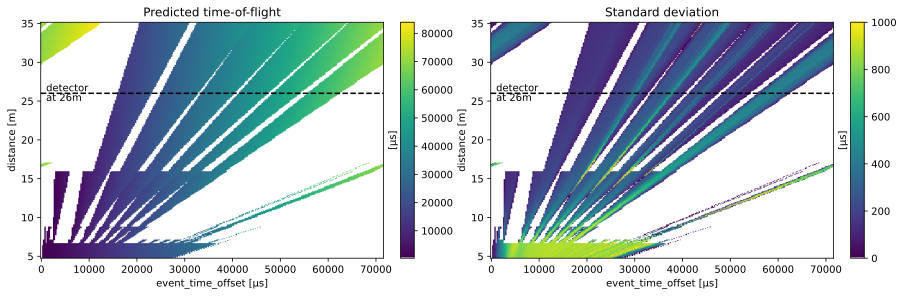

In [14]:
def plot_lut(table):
    fig = table.plot(title="Predicted time-of-flight") + sc.stddevs(table.array).plot(title="Standard deviation", vmax=1000)
    for f in (fig[0, 0], fig[0, 1]):
        f.ax.axhline(Ltotal.value, ls='dashed', color='k')
        f.ax.text(1e3, Ltotal.value, "detector", va='bottom', color='k')
        f.ax.text(1e3, Ltotal.value, "at 26m", va='top', color='k')
    return fig

plot_lut(table)

We can see that at low distances (< 7m), before the first choppers, the uncertainties are very large.
Neutrons with different wavelengths, originating from different parts of the pulse, are mixing and make it very difficult to predict a good time-of-flight.

As we move to larger distances, uncertainties drop overall (colors drift to blue).
However, we still see spikes of uncertainties inside the frames around 26 m where the detector is placed,
which indicates contamination from neighbouring chopper openings.

#### Optionally masking out large uncertainties

It is actually possible to mask out regions of large uncertainty using the `LookupTableRelativeErrorThreshold` parameter.

Because we may want to use different uncertainty criteria for different experimental runs as well as different components in the beamline (monitors, multiple detector banks),
the masking is not hard-coded in the table but a parameter that is applied on-the-fly in the original workflow which computes time-of-flight.

We thus first update that workflow by setting the newly computed `table` as the `TofLookupTable` parameter.
Next, we apply a threshold for the `detector` component and inspect the masked table:

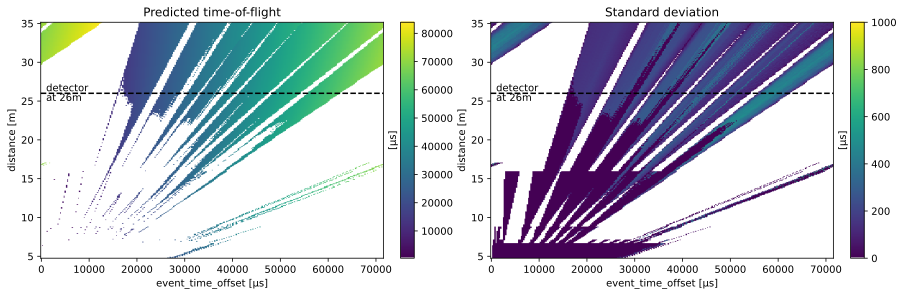

In [15]:
wf[TofLookupTable] = table
wf[LookupTableRelativeErrorThreshold] = {"detector": 0.01}

masked = wf.compute(ErrorLimitedTofLookupTable[snx.NXdetector])

plot_lut(masked)

As we can see in the left panel, the regions in the table with large uncertainties are now white (they have been assigned a NaN value).
However, the masking is not very smooth, and it would also mean that a large number of events in these white regions would be discarded in the final reduced result.

The contamination from neighbouring chopper openings is actually relatively small,
and we instead decide to live with that uncertainty and set the threshold to infinity to remove any masking in the table.

In [16]:
wf[LookupTableRelativeErrorThreshold] = {"detector": np.inf}

### Computing a time-of-flight coordinate

We will now compute our event data with a time-of-flight coordinate:

In [17]:
tofs = wf.compute(TofDetector[SampleRun])
tofs

<scipp.DataArray>
Dimensions: Sizes[detector_number:1, ]
Coordinates:
* Ltotal                    float64              [m]  ()  26
Data:
                          DataArrayView        <no unit>  (detector_number)  binned data: dim='event', content=DataArray(
          dims=(event: 204163),
          data=float64[counts],
          coords={'id':int64, 'eto':float64[µs], 'event_time_zero':datetime64[µs],
                  'tof':float64[µs]})

Histogramming the data for a plot should show a profile with 6 bumps that correspond to the frames:

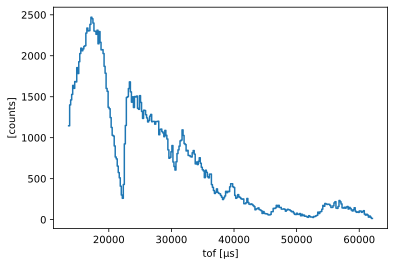

In [18]:
tofs.bins.concat().hist(tof=300).plot()

### Converting to wavelength

We can now convert our new time-of-flight coordinate to a neutron wavelength, using `tranform_coords`:

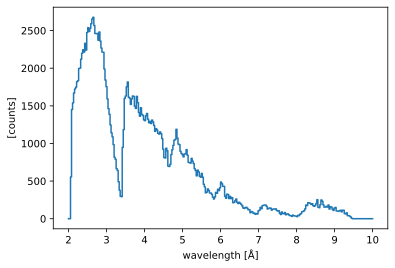

In [19]:
from scippneutron.conversion.graph.beamline import beamline
from scippneutron.conversion.graph.tof import elastic

# Perform coordinate transformation
graph = {**beamline(scatter=False), **elastic("tof")}
wav_wfm = tofs.transform_coords("wavelength", graph=graph)

# Define wavelength bin edges
wavs = sc.linspace("wavelength", 2, 10, 301, unit="angstrom")

histogrammed = wav_wfm.hist(wavelength=wavs).squeeze()
histogrammed.plot()

### Comparing to the ground truth

As a consistency check, because we actually know the wavelengths of the neutrons we created,
we can compare the true neutron wavelengths to those we computed above.

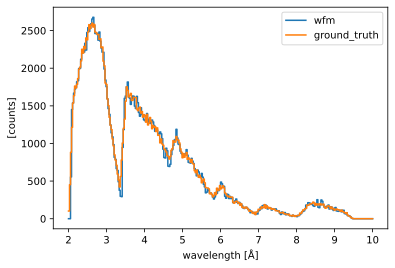

In [20]:
ground_truth = ess_beamline.model_result["detector"].data.flatten(to="event")
ground_truth = ground_truth[~ground_truth.masks["blocked_by_others"]]

pp.plot(
    {
        "wfm": histogrammed,
        "ground_truth": ground_truth.hist(wavelength=wavs),
    }
)